# Dfsu - Speed and direction

In [1]:
import numpy as np
import mikeio

In [2]:
ds = mikeio.read("../tests/testdata/HD2D.dfsu")
ds

<mikeio.Dataset>
dims: (time:9, element:884)
time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00 (9 records)
geometry: Dfsu2D (884 elements, 529 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)

This file is missing current direction :-(

Lets'fix that!

## Calculate speed & direction

In [3]:
ds.U_velocity

<mikeio.DataArray>
name: U velocity
dims: (time:9, element:884)
time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00 (9 records)
geometry: Dfsu2D (884 elements, 529 nodes)

In order to use Numpy functions on a DataArray, we first convert the DataArrays (U, V) to standard NumPy ndarrays.

In [4]:
u = ds.U_velocity.to_numpy()
v = ds.V_velocity.to_numpy()

In [5]:
direction = np.mod(90 -np.rad2deg(np.arctan2(v,u)),360)

## Write new file

In [17]:
ds["Current direction"] = mikeio.DataArray(
    direction,
    time=ds.time,
    name="Current direction",
    type=mikeio.EUMType.Current_Direction,
    unit=mikeio.EUMUnit.degree,
    geometry=ds.geometry,
)
ds

<mikeio.Dataset>
dims: (time:9, element:884)
time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00 (9 records)
geometry: Dfsu2D (884 elements, 529 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)
  4:  Current direction <Current Direction> (degree)

In [7]:
ds.to_dfs("speed_direction.dfsu")

In [8]:
nds = mikeio.read("speed_direction.dfsu")
nds

<mikeio.Dataset>
dims: (time:9, element:884)
time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00 (9 records)
geometry: Dfsu2D (884 elements, 529 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  U velocity <u velocity component> (meter per sec)
  2:  V velocity <v velocity component> (meter per sec)
  3:  Current speed <Current Speed> (meter per sec)
  4:  Current direction <Current Direction> (degree)

# Plot

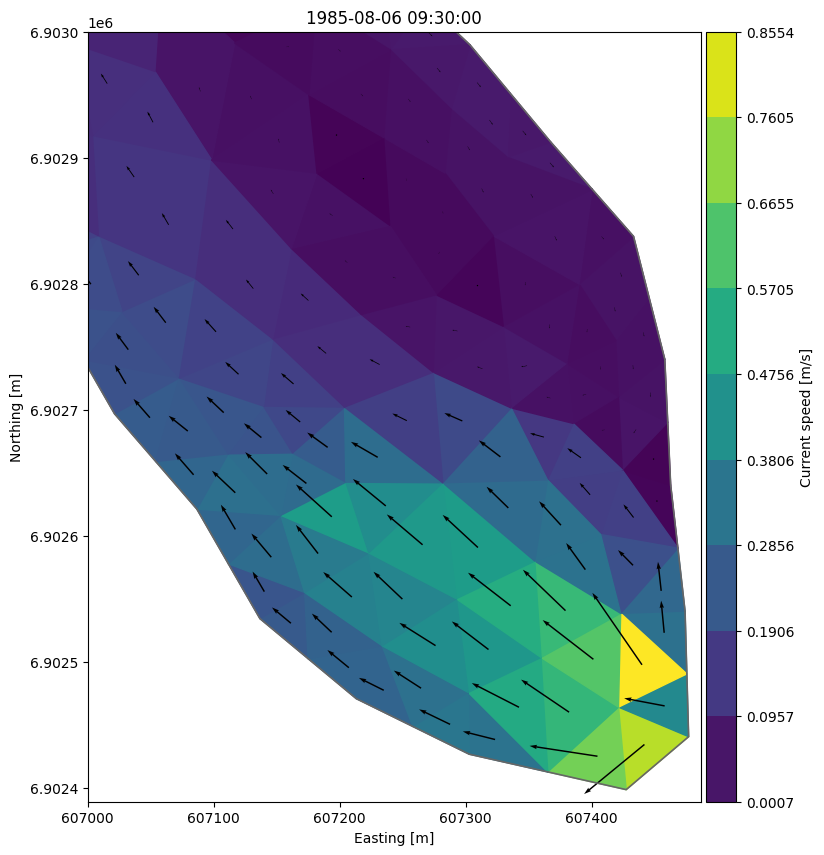

In [9]:
step = 1

ax = ds.Current_speed[step].plot(figsize=(10,10))
ax.set_ylim([None, 6903000])
ax.set_xlim([607000, None])
ec = ds.geometry.element_coordinates
x = ec[:,0]
y = ec[:,1]
u = ds.U_velocity.to_numpy()
v = ds.V_velocity.to_numpy()
ax.quiver(x, y, u[step], v[step], scale=6, minshaft=3);

## Plot quiver on Cartesian overlay instead 
Create overset grid and interpolate data on to this

In [10]:
g = ds.geometry.get_overset_grid(dx=50)
g

<mikeio.Grid2D>
x: [6.059e+05, 6.059e+05, ..., 6.075e+05] (nx=33, dx=50)
y: [6.902e+06, 6.902e+06, ..., 6.907e+06] (ny=93, dy=50)
projection: UTM-29

In [11]:
g.projection

'UTM-29'

In [12]:
ui = ds.U_velocity.interp_like(g)
vi = ds.V_velocity.interp_like(g)

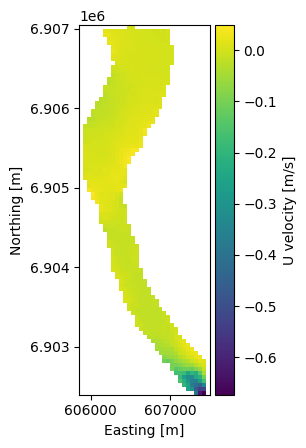

In [13]:
ui.plot();

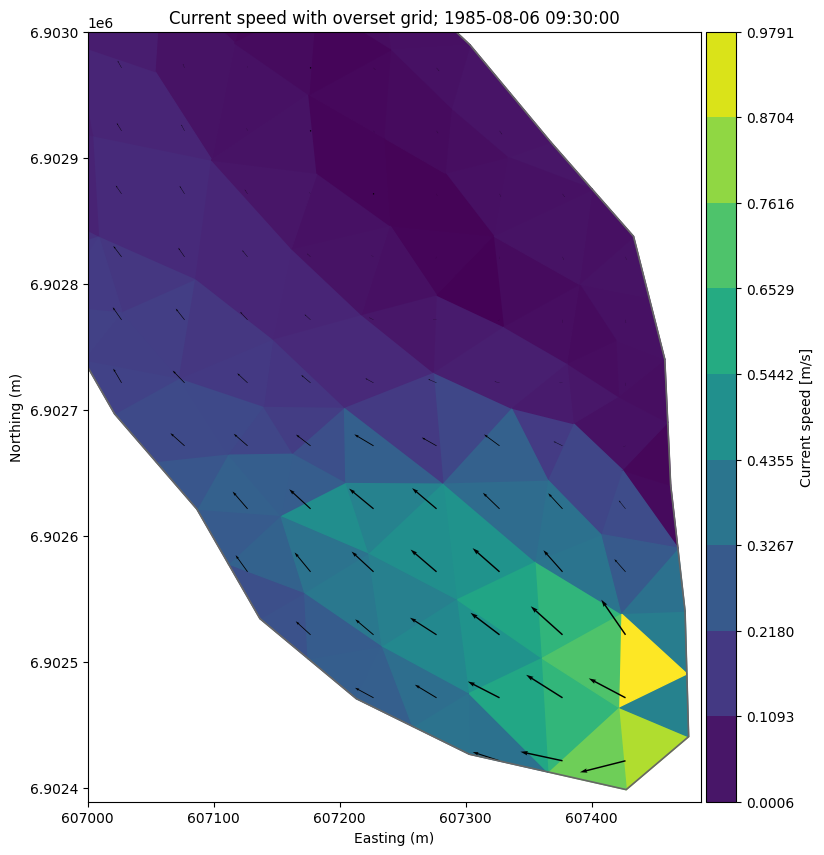

In [14]:
ax = ds.Current_speed.plot(figsize=(10,10))

u = ui.to_numpy()
v = vi.to_numpy()
ax.quiver(g.x, g.y, u[step], v[step], scale=8, minshaft=5)

ax.set_ylim([None, 6903000])
ax.set_xlim([607000, None])
ax.set_title(f'Current speed with overset grid; {ds.time[step]}')
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)");

## Clean up

In [15]:
import os
os.remove("speed_direction.dfsu")